## Deep Gaussian Processes for Bayesian Optimization

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
from pylab import *
%matplotlib inline
import os
from sys import path
np.random.seed(42)

# Add parent directory to path if deepgp is not there already
pwd = os.getcwd()
base_path = pwd[0:pwd.rfind(os.sep)]
path.insert(0,base_path)

import deepgp

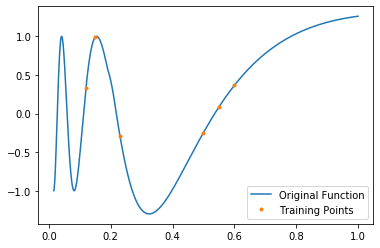

In [23]:
X = np.linspace(0.0157, 1, 1000)
Xts = np.array([0.12 ,0.15, 0.23, 0.50, 0.55 , 0.60])
Y = (np.sin(2/(0.1+X)))*( 1 + 0.3*((X-0.19)/0.02)*(X < 0.21)*(X > 0.19) + 0.3*(X > 0.21)  )
Yts = (np.sin(2/(0.1+Xts)))*( 1 + 0.3*((Xts-0.19)/0.02)*(Xts < 0.21)*(Xts > 0.19) + 0.3*(Xts > 0.21)  )
plt.plot(X,Y, label = "Original Function")

#plt.plot(Xts, Yts, ".", label = "Training Points")
#plt.legend()

#Y = (np.sin(2/(0.1+X)))*( 1 + 0.3*((X-0.19)/0.02)*(X < 0.21)*(X > 0.19) + 0.3*(X > 0.21)  ) 

x = Xts[:,None]
y = Yts[:,None]

plt.plot(x, y, ".", label = "Training Points")
plt.legend()

offset = y.mean()
scale = np.sqrt(y.var())
yhat = (y-offset)/scale

In [16]:
hidden = 2
m = deepgp.DeepGP([y.shape[1],hidden,x.shape[1]],Y=yhat, X=x, 
                  kernels=[GPy.kern.RBF(hidden,ARD=True),
                           GPy.kern.RBF(x.shape[1],ARD=True)], # the kernels for each layer
                  num_inducing=6, back_constraint=False)

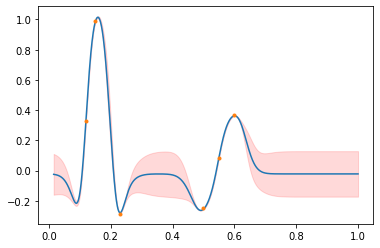

In [17]:
# Make sure initial noise variance gives a reasonable signal to noise ratio.
# Fix to that value for a few iterations to avoid early local minima
for i in range(len(m.layers)):
    output_var = m.layers[i].Y.var() if i==0 else m.layers[i].Y.mean.var()
    m.layers[i].Gaussian_noise.variance = output_var*0.001
    m.layers[i].Gaussian_noise.variance.fix()
    
m.optimize(messages=True,max_iters=600)

"""
for i in range(len(m.layers)):
    m.layers[i].Gaussian_noise.variance.unfix()
for i in range(10):
    Xtest = np.linspace(0.0157,1,1000)
    Ypredict = m.predict(Xtest[:,None])
    plt.figure(int(i))
    plt.plot(Xtest, Ypredict[0]*scale + offset)
    plt.fill_between(Xtest, Ypredict[0][:,0]*scale + offset-2*Ypredict[1][:,0]*scale**2, Ypredict[0][:,0]*scale + offset+2*Ypredict[1][:,0]*scale**2, color='red', alpha=0.15, label='$2 \sigma_{2|1}$')
    plt.plot(x, y, '.')
    plt.title("Optimization number " + str(i))
    m.optimize(max_iters=30, messages=True)
""" 
    
Xtest = np.linspace(0.0157,1,1000)
Ypredict = m.predict(Xtest[:,None])
plt.plot(Xtest, Ypredict[0]*scale + offset)
plt.fill_between(Xtest, Ypredict[0][:,0]*scale + offset - 2*Ypredict[1][:,0]*scale**2, Ypredict[0][:,0]*scale + offset +2*Ypredict[1][:,0]*scale**2, color='red', alpha=0.15, label='$2 \sigma_{2|1}$')
plt.plot(x, y, '.')

In [24]:
hidden = 2
bo = deepgp.BayesianOptimization([[y.shape[1],hidden,x.shape[1]], [GPy.kern.RBF(hidden,ARD=True),
                           GPy.kern.RBF(x.shape[1],ARD=True)], 6], lambda X: (np.sin(2/(0.1+X)))*(1 + 0.3*((X-0.19)/0.02)*(X < 0.21)*(X > 0.19) + 0.3*(X > 0.21)),y, x, 20000, 600, [np.array([0.]), np.array([1.])])

Train model with
-6 Inducing points
-6Observation points
[[0.12]
 [0.15]
 [0.23]
 [0.5 ]
 [0.55]
 [0.6 ]]
[[ 0.32770071]
 [ 0.98935825]
 [-0.28696977]
 [-0.24773835]
 [ 0.08401186]
 [ 0.36481822]]


Train model with
-17 Inducing points
-17Observation points
[[0.12      ]
 [0.15      ]
 [0.23      ]
 [0.5       ]
 [0.55      ]
 [0.6       ]
 [0.32064128]
 [0.36673347]
 [0.82965932]
 [0.90180361]
 [0.05611222]
 [0.41683367]
 [1.        ]
 [0.72344689]
 [0.9498998 ]
 [0.        ]
 [0.        ]]
[[ 0.32770071]
 [ 0.98935825]
 [-0.28696977]
 [-0.24773835]
 [ 0.08401186]
 [ 0.36481822]
 [-1.29883955]
 [-1.1831208 ]
 [ 1.08702414]
 [ 1.18402694]
 [ 0.24248446]
 [-0.86511195]
 [ 1.26042273]
 [ 0.85011924]
 [ 1.22809737]
 [ 0.91294525]
 [ 0.91294525]]


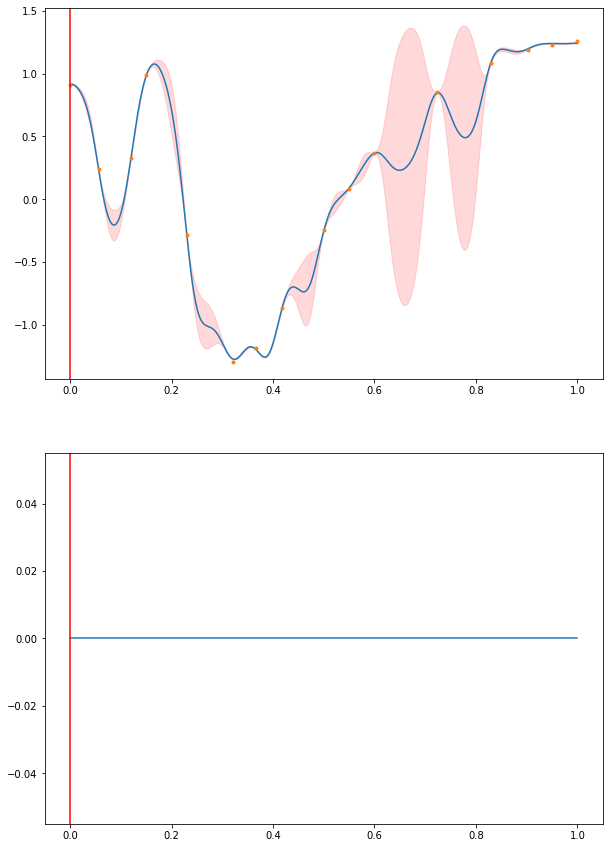

In [35]:
bo.perform_step()

Train model with
-12 Inducing points
-12Observation points
-12Observation points


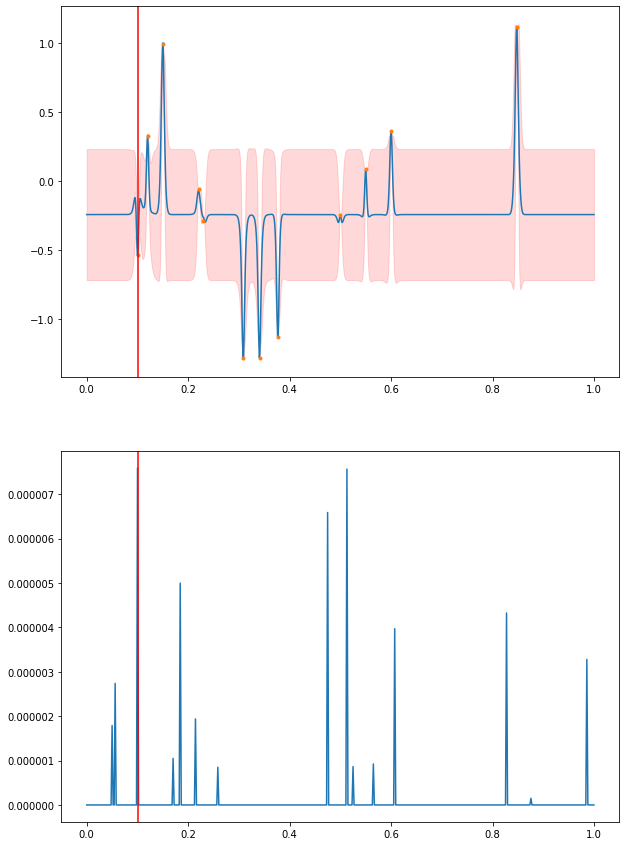

In [82]:
bo._update()
bo.plot()

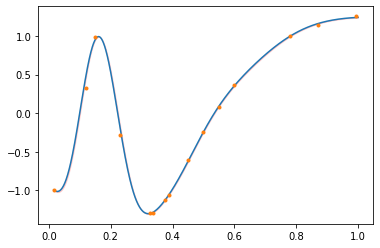

In [13]:
x = bo.x
y = bo.y
offset = y.mean()
scale = np.sqrt(y.var())
yhat = (y-offset)/scale 

hidden = 2
m = deepgp.DeepGP([y.shape[1],hidden,x.shape[1]],Y=yhat, X=x, 
                  kernels=[GPy.kern.RBF(hidden,ARD=True),
                           GPy.kern.RBF(x.shape[1],ARD=True)], # the kernels for each layer
                  num_inducing= x.shape[0], back_constraint=False)

for i in range(len(m.layers)):
    output_var = m.layers[i].Y.var() if i==0 else m.layers[i].Y.mean.var()
    m.layers[i].Gaussian_noise.variance = output_var*0.001
    m.layers[i].Gaussian_noise.variance.fix()
    
m.optimize(messages=True,max_iters=600)

Xtest = np.linspace(0.0157,1,1000)
Ypredict = m.predict(Xtest[:,None])
plt.plot(Xtest, Ypredict[0]*scale + offset)
plt.fill_between(Xtest, Ypredict[0][:,0]*scale + offset - 2*Ypredict[1][:,0]*scale**2, Ypredict[0][:,0]*scale + offset +2*Ypredict[1][:,0]*scale**2, color='red', alpha=0.15, label='$2 \sigma_{2|1}$')
plt.plot(x, y, '.')

In [23]:
hidden = 2
bo = deepgp.BayesianOptimization([[y.shape[1],hidden,x.shape[1]], [GPy.kern.RBF(hidden,ARD=True),
                           GPy.kern.RBF(x.shape[1],ARD=True)], 8], lambda X: (np.sin(2/(0.1+X)))*(1 + 0.3*((X-0.19)/0.02)*(X < 0.21)*(X > 0.19) + 0.3*(X > 0.21)),y, x, 20000, 600, [np.array([0.]), np.array([1.])])

Train model with
-8 Inducing points
-8Observation points
-8Observation points


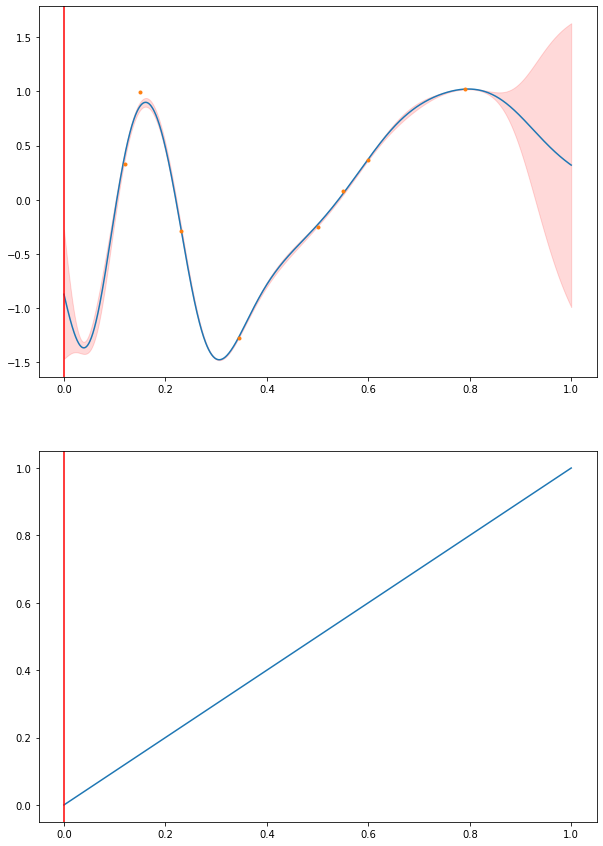

In [32]:
bo.nextpoint = 0
bo.currentEI = [[0,1], [0,1]]
bo.plot()

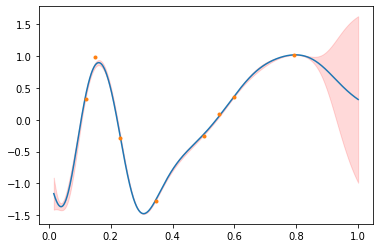

In [29]:
Ypredict = bo.compute_predictive(Xtest[:,None])
plt.plot(Xtest, Ypredict[0]*scale + offset)
plt.fill_between(Xtest, Ypredict[0][:,0]*scale + offset - 2*Ypredict[1][:,0]*scale**2, Ypredict[0][:,0]*scale + offset +2*Ypredict[1][:,0]*scale**2, color='red', alpha=0.15, label='$2 \sigma_{2|1}$')
plt.plot(x, y, '.')

In [28]:
Ypredict

(array([[-1.83805094]]), array([[0.25853675]]))

In [26]:
Xtest

array([0.0157    , 0.01668529, 0.01767057, 0.01865586, 0.01964114,
       0.02062643, 0.02161171, 0.022597  , 0.02358228, 0.02456757,
       0.02555285, 0.02653814, 0.02752342, 0.02850871, 0.02949399,
       0.03047928, 0.03146456, 0.03244985, 0.03343514, 0.03442042,
       0.03540571, 0.03639099, 0.03737628, 0.03836156, 0.03934685,
       0.04033213, 0.04131742, 0.0423027 , 0.04328799, 0.04427327,
       0.04525856, 0.04624384, 0.04722913, 0.04821441, 0.0491997 ,
       0.05018498, 0.05117027, 0.05215556, 0.05314084, 0.05412613,
       0.05511141, 0.0560967 , 0.05708198, 0.05806727, 0.05905255,
       0.06003784, 0.06102312, 0.06200841, 0.06299369, 0.06397898,
       0.06496426, 0.06594955, 0.06693483, 0.06792012, 0.06890541,
       0.06989069, 0.07087598, 0.07186126, 0.07284655, 0.07383183,
       0.07481712, 0.0758024 , 0.07678769, 0.07777297, 0.07875826,
       0.07974354, 0.08072883, 0.08171411, 0.0826994 , 0.08368468,
       0.08466997, 0.08565526, 0.08664054, 0.08762583, 0.08861

In [12]:
bo.compute_nextpoint()

array([0.21212121])

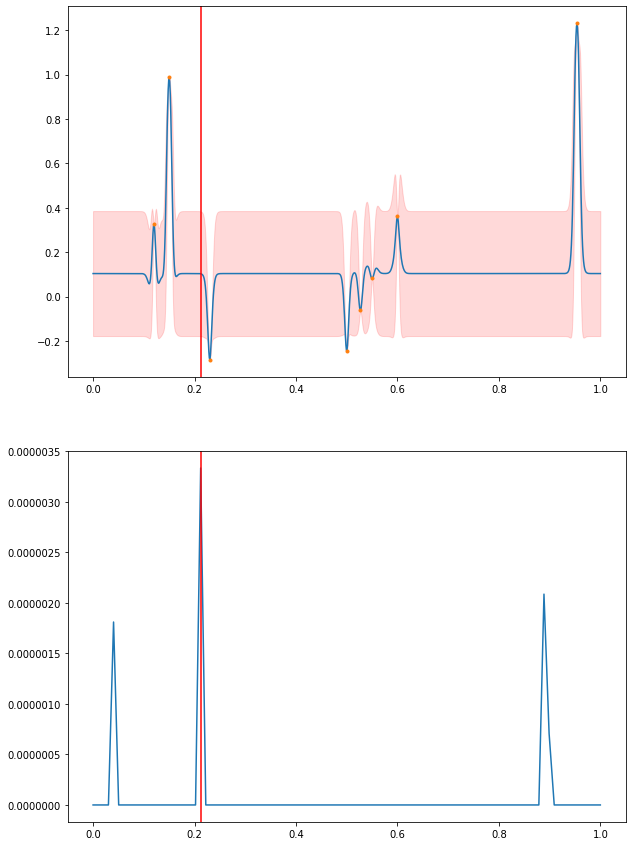

In [13]:
bo.plot()

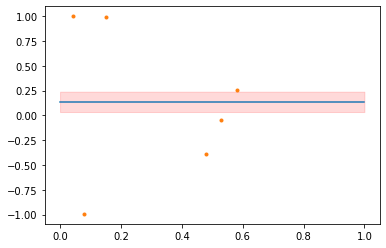

In [11]:
m_GP = GPy.models.GPRegression(X=x, Y=yhat, kernel = GPy.kern.RBF(x.shape[1]))

m_GP.Gaussian_noise.variance = m_GP.Y.var()*0.1
m_GP.Gaussian_noise.variance.fix()
m_GP.optimize(max_iters=400, messages=True)
#m_GP.Gaussian_noise.variance.unfix()
#m_GP.optimize(max_iters=400, messages=True)

Xtest = np.linspace(0.,1,1000)
Y_pred_GP = m_GP.predict(Xtest[:,None])


plt.plot(Xtest, Y_pred_GP[0]*scale + offset)
plt.fill_between(Xtest, Y_pred_GP[0][:,0]*scale + offset-2*Y_pred_GP[1][:,0]*scale**2, Y_pred_GP[0][:,0]*scale + offset+2*Y_pred_GP[1][:,0]*scale**2, color='red', alpha=0.15, label='$2 \sigma_{2|1}$')
plt.plot(x, y, '.')

In [12]:
l = np.array([[1,2]])

In [26]:
l2 = np.stack((l,np.array([[1,2]])), axis = 0)

In [30]:
a = np.array([1, 2, 3])
b = np.array([2, 3, 4])
c= np.vstack((a,b))

In [31]:
np.vstack((c,a))

array([[1, 2, 3],
       [2, 3, 4],
       [1, 2, 3]])